In [1]:
import os
import csv
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Cropping2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


In [2]:
def get_sample_data(path, ignore_first_line=True):
    # Read In Log File
    samples = [] # each line of the CSV file
    with open(path) as csvfile:
        reader = csv.reader(csvfile)
        first_line = ignore_first_line
        for line in reader:
            if first_line:
                first_line = False
                continue
            samples.append(line)
    return samples

In [3]:
save_path = "model.h5"
image_data_file_path = "data/IMG/"
log_file_path1 = "data/driving_log.csv"
log_file_path2 = "data/driving_log2.csv"

In [4]:
all_samples = get_sample_data(log_file_path1)
all_samples.extend(get_sample_data(log_file_path2))
all_samples = np.array(all_samples)

## Distribution

#### All Samples

In [5]:
def analyze_samples(data):
    steering = dict()
    data = np.array(data)
    angles = data[:, 3]
    for i in angles:
        i = float(i)
        if i not in steering:
            steering[i] = 1
        else:
            steering[i] += 1
    return steering

def redistribute_samples(data, count_map):
    # Get the distribution of keep probability 
    average = np.average(list(count_map.values()))
    keep_prob = dict()
    for i in count_map:
        if count_map[i] <= average:
            keep_prob[i] = 1
        else:
            keep_prob[i] = average / count_map[i]
    # Resample Data
    new_data = list()
    for line in data:
        angle = float(line[3])
        if np.random.random() <= keep_prob[angle]:
            new_data.append(line)
    return np.array(new_data)

def plot_distribution(samples):
    distribution = analyze_samples(samples)
    plt.bar(list(distribution.keys()), list(distribution.values()), width=0.1)

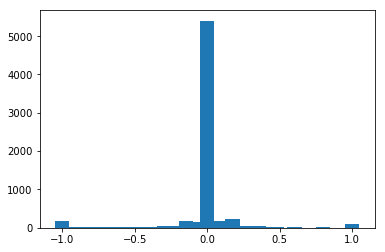

In [6]:
plot_distribution(all_samples)

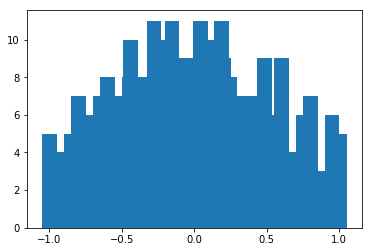

In [7]:
plot_distribution((redistribute_samples(all_samples, analyze_samples(all_samples))))

####  Track 1 Samples

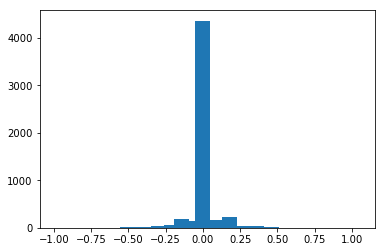

In [8]:
track1_samples = get_sample_data(log_file_path1)
plot_distribution(track1_samples)

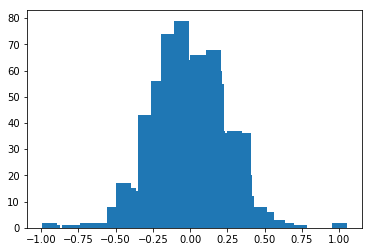

In [9]:
plot_distribution((redistribute_samples(track1_samples, analyze_samples(track1_samples))))

####  Track 2 Samples

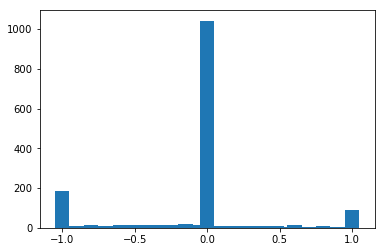

In [10]:
track2_samples = get_sample_data(log_file_path2)
plot_distribution(track2_samples)

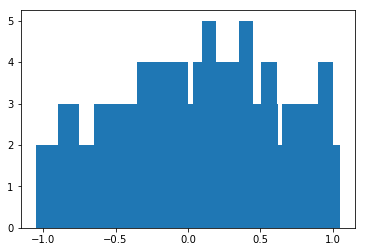

In [11]:
plot_distribution((redistribute_samples(track2_samples, analyze_samples(track2_samples))))

## Visualization

In [6]:
img1_path = "IMG/center_2016_12_01_13_42_21_093.jpg"
img2_path = "IMG/center_2017_07_14_18_50_08_171.jpg"

In [7]:
def get_path(path):
    return image_data_file_path + path.split('/')[-1]
def convert_to_RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### Original

In [8]:
img1 = convert_to_RGB(cv2.imread(get_path(img1_path)))
img2 = convert_to_RGB(cv2.imread(get_path(img2_path)))

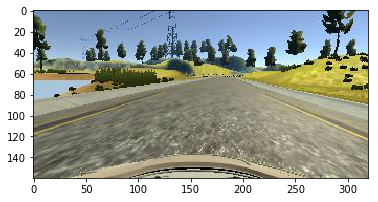

In [9]:
plt.imshow(img1)

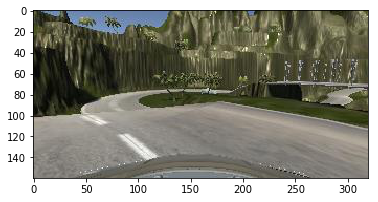

In [10]:
plt.imshow(img2)

#### Left and Right Camera

In [11]:
left_img1 = convert_to_RGB(cv2.imread(get_path(img1_path.replace('center','left'))))
left_img2 = convert_to_RGB(cv2.imread(get_path(img2_path.replace('center','left'))))

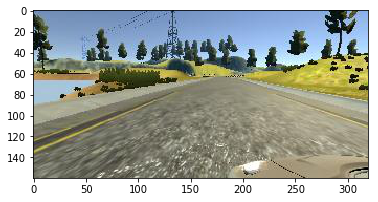

In [12]:
plt.imshow(left_img1)

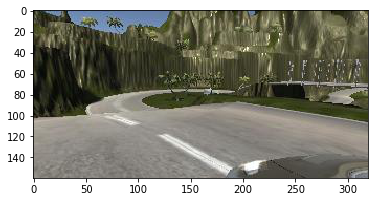

In [13]:
plt.imshow(left_img2)

In [14]:
right_img1 = convert_to_RGB(cv2.imread(get_path(img1_path.replace('center','right'))))
right_img2 = convert_to_RGB(cv2.imread(get_path(img2_path.replace('center','right'))))

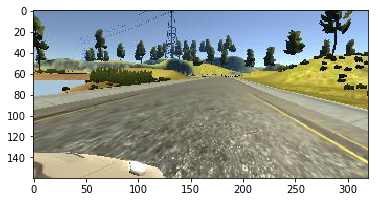

In [15]:
plt.imshow(right_img1)

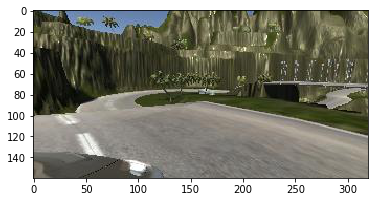

In [17]:
plt.imshow(right_img2)

### Flip

In [17]:
def flip(img):
    return np.fliplr(img)

In [18]:
img1_flip = flip(img1)
img2_flip = flip(img2)

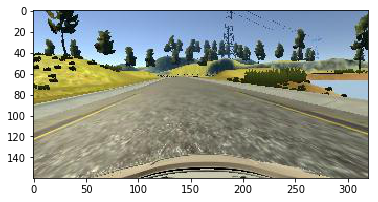

In [19]:
plt.imshow(img1_flip)

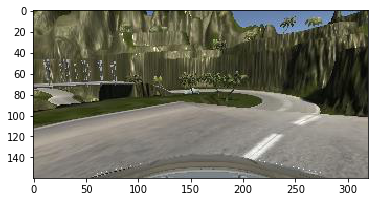

In [20]:
plt.imshow(img2_flip)

### Gaussian Blur

In [21]:
def gaussian_blur(img, kernel_size=7):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [22]:
img1_blur = gaussian_blur(img1)
img2_blur = gaussian_blur(img2)

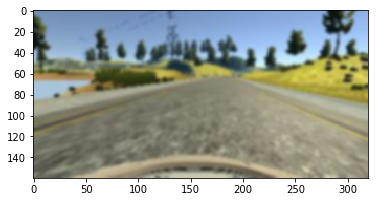

In [23]:
plt.imshow(img1_blur)

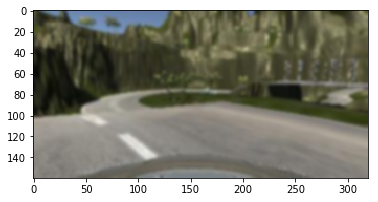

In [24]:
plt.imshow(img2_blur)

### Adjust Brightness

In [25]:
def adjust_brightness_RGB(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    ratio = 0.9 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    print("Ratio", ratio)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

Ratio 0.7527145288615532


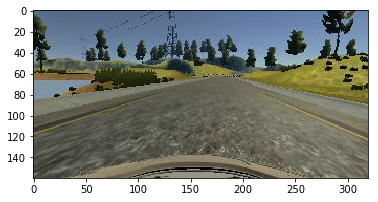

In [27]:
img1_brightness = adjust_brightness_RGB(img1)
plt.imshow(img1_brightness)

Ratio 0.8285113362804654


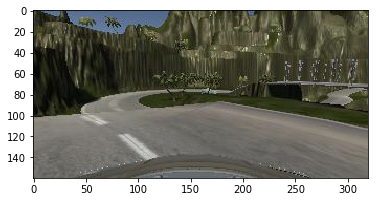

In [29]:
img2_brightness = adjust_brightness_RGB(img2)
plt.imshow(img2_brightness)

### Random Transform

In [30]:
def random_translate(image, steering_angle, range_x=100, range_y=10):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

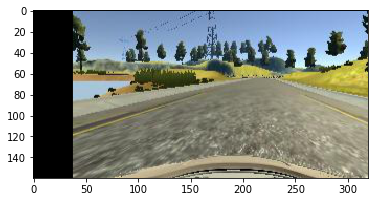

In [31]:
placeholder_steer_angle = 0
img1_translate, _ = random_translate(img1, placeholder_steer_angle)
plt.imshow(img1_translate)

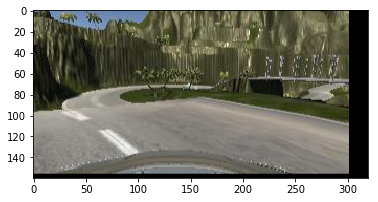

In [36]:
placeholder_steer_angle = 0
img2_translate, _ = random_translate(img2, placeholder_steer_angle)
plt.imshow(img2_translate)

### Random Shadow

In [37]:
def random_shadow(image):
    """
    Generates and adds random shadow
    """
    IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = image.shape
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

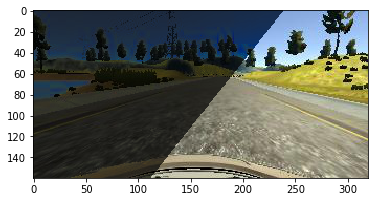

In [39]:
img1_shadow = random_shadow(img1)
plt.imshow(img1_shadow)

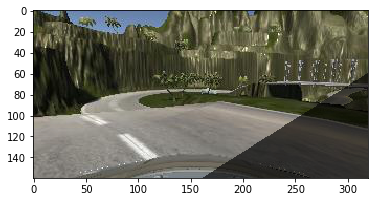

In [40]:
img2_shadow = random_shadow(img2)
plt.imshow(img2_shadow)

### Augmentation

In [46]:
def use_augmentation(prob):
        return True if np.random.random() <= prob else False
def augment(new_img, new_angle):
    augmented = False
    new_img = gaussian_blur(new_img)
    if augment and use_augmentation(0.4):
        new_img, new_angle = adjust_brightness_RGB(new_img), new_angle
        augmented = True
    if augment and use_augmentation(0.2):
        new_img, new_angle = random_shadow(new_img), new_angle
        augmented = True
    if augment and use_augmentation(0.3):
        new_img, new_angle = random_translate(new_img, new_angle)
        augmented = True
    if not augmented or use_augmentation(0.4):
        new_img, new_angle = flip(new_img), -new_angle

    return new_img, new_angle

Ratio 0.7779236493387727


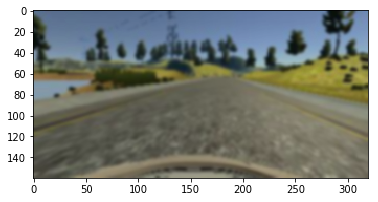

In [47]:
placeholder_steer_angle = 0
img1_augment, _ = augment(img1, placeholder_steer_angle)
plt.imshow(img1_augment)

Ratio 0.8235213608688934


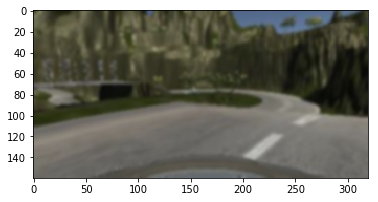

In [48]:
placeholder_steer_angle = 0
img2_augment, _ = augment(img2, placeholder_steer_angle)
plt.imshow(img2_augment)